# 1.2 Construção do Modelo

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from show_results import plot_confusion_matrix, get_accuracy, get_precision, f_score
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
import xgboost as xgb

## 1.2.1 Abrindo o dataset e tratando os dados

In [2]:
data = pd.read_csv('PCOS.csv')

In [3]:
data.head(2)

,Unnamed: 0,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,0,1,1,0,28,44.6,152.0,19.3,15,78,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,1,2,2,0,36,65.0,161.5,24.9,15,74,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7


In [4]:
data.dropna(inplace=True)

In [5]:
data = data.replace({'1.99.': 1.99})

In [6]:
del data["Sl. No"]
del data["Patient File No."]
del data["Unnamed: 0"]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539 entries, 0 to 540
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PCOS (Y/N)              539 non-null    int64  
 1    Age (yrs)              539 non-null    int64  
 2   Weight (Kg)             539 non-null    float64
 3   Height(Cm)              539 non-null    float64
 4   BMI                     539 non-null    float64
 5   Blood Group             539 non-null    int64  
 6   Pulse rate(bpm)         539 non-null    int64  
 7   RR (breaths/min)        539 non-null    int64  
 8   Hb(g/dl)                539 non-null    float64
 9   Cycle(R/I)              539 non-null    int64  
 10  Cycle length(days)      539 non-null    int64  
 11  Marraige Status (Yrs)   539 non-null    float64
 12  Pregnant(Y/N)           539 non-null    int64  
 13  No. of abortions        539 non-null    int64  
 14    I   beta-HCG(mIU/mL)  539 non-null    fl

In [8]:
data[data['AMH(ng/mL)'] == "a"]

,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
305,0,37,56.0,152.0,24.2,13,74,20,11.7,2,...,1,0.0,1,120,70,4,5,17.0,16.0,5.6


In [9]:
data.drop([305], inplace=True)

In [10]:
data['II    beta-HCG(mIU/mL)'] = pd.to_numeric(data['II    beta-HCG(mIU/mL)'])

In [11]:
data['AMH(ng/mL)'] = pd.to_numeric(data['AMH(ng/mL)'])

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 538 entries, 0 to 540
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PCOS (Y/N)              538 non-null    int64  
 1    Age (yrs)              538 non-null    int64  
 2   Weight (Kg)             538 non-null    float64
 3   Height(Cm)              538 non-null    float64
 4   BMI                     538 non-null    float64
 5   Blood Group             538 non-null    int64  
 6   Pulse rate(bpm)         538 non-null    int64  
 7   RR (breaths/min)        538 non-null    int64  
 8   Hb(g/dl)                538 non-null    float64
 9   Cycle(R/I)              538 non-null    int64  
 10  Cycle length(days)      538 non-null    int64  
 11  Marraige Status (Yrs)   538 non-null    float64
 12  Pregnant(Y/N)           538 non-null    int64  
 13  No. of abortions        538 non-null    int64  
 14    I   beta-HCG(mIU/mL)  538 non-null    fl

## Usando a correlação de Pearson para encontrar os melhores atributos preditores

In [13]:
X = data.drop(columns=['PCOS (Y/N)'], axis=1)
y = data["PCOS (Y/N)"]

In [14]:
correlations = []
for col in X.columns:
    corr, _ = pearsonr(X[col], y)
    correlations.append(corr)

# obtendo o módulo dos coeficientes de correlação
correlations = map(math.fabs, correlations)


# criar um dicionário de features e seus coeficientes de correlação
corr_dict = dict(zip(X.columns, correlations))


# ordena o dicionário por coeficiente de correlação em ordem decrescente
sorted_corr_dict = {k: v for k, v in sorted(corr_dict.items(), key=lambda item: item[1], reverse=True)}

N = 20
selected_features = list(sorted_corr_dict.keys())[:N]


X_selected = X[selected_features]

In [15]:
correlation = data.corr()
correlation["PCOS (Y/N)"].sort_values(ascending=False)

PCOS (Y/N)                1.000000
Follicle No. (R)          0.650929
Follicle No. (L)          0.601208
Skin darkening (Y/N)      0.481323
hair growth(Y/N)          0.466508
Weight gain(Y/N)          0.443093
Cycle(R/I)                0.401837
Fast food (Y/N)           0.380985
Pimples(Y/N)              0.290335
AMH(ng/mL)                0.263974
Weight (Kg)               0.209969
BMI                       0.198854
Hair loss(Y/N)            0.176496
Waist(inch)               0.161922
Hip(inch)                 0.160882
Avg. F size (L) (mm)      0.129997
Endometrium (mm)          0.107639
Avg. F size (R) (mm)      0.094528
Pulse rate(bpm)           0.092699
Hb(g/dl)                  0.087809
Vit D3 (ng/mL)            0.085825
Reg.Exercise(Y/N)         0.071979
Height(Cm)                0.065465
LH(mIU/mL)                0.064074
RBS(mg/dl)                0.049452
RR (breaths/min)          0.038641
Blood Group               0.033701
BP _Diastolic (mmHg)      0.033562
II    beta-HCG(mIU/m

In [16]:
X_selected

,Follicle No. (R),Follicle No. (L),Skin darkening (Y/N),hair growth(Y/N),Weight gain(Y/N),Cycle(R/I),Fast food (Y/N),Pimples(Y/N),AMH(ng/mL),Weight (Kg),BMI,Cycle length(days),Hair loss(Y/N),Age (yrs),Waist(inch),Hip(inch),Avg. F size (L) (mm),Marraige Status (Yrs),Endometrium (mm),Avg. F size (R) (mm)
0,3,3,0,0,0,2,1.0,0,2.07,44.6,19.3,5,0,28,30,36,18.0,7.0,8.5,18.0
1,5,3,0,0,0,2,0.0,0,1.53,65.0,24.9,5,0,36,32,38,15.0,11.0,3.7,14.0
2,15,13,0,0,0,2,1.0,1,6.63,68.8,25.3,5,1,33,36,40,18.0,10.0,10.0,20.0
3,2,2,0,0,0,2,0.0,0,1.22,65.0,29.7,5,0,37,36,42,15.0,4.0,7.5,14.0
4,4,3,0,0,0,2,0.0,0,2.26,52.0,20.1,5,1,25,30,37,16.0,1.0,7.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,0,1,0,0,0,2,0.0,0,1.70,50.0,18.5,5,0,35,26,28,17.5,8.0,6.7,10.0
537,7,9,0,0,1,2,0.0,0,5.60,63.2,25.3,5,0,30,32,34,19.0,4.0,8.2,18.0
538,0,1,0,0,0,2,0.0,0,3.70,54.0,23.4,6,0,36,28,30,18.0,8.0,7.3,9.0
539,6,7,0,0,0,4,0.0,1,5.20,50.0,22.2,2,0,27,26,28,18.0,2.0,11.5,16.0


## Separando o conjunto de testes e treino

Partição 70/30

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y,test_size=0.30)

X_train.shape, X_test.shape, (y_test == 1).sum(), (y_test == 0).sum()

((376, 20), (162, 20), 57, 105)

### Normalizando os atributos preditores

In [18]:
X_train_norm = (X_train - np.min(X_train))/(np.max(X_train) - np.min(X_train))

C:\Users\Callidus\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Callidus\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [19]:
X_test_norm = (X_test - np.min(X_train))/(np.max(X_train) - np.min(X_train))

## Estimando o número de neurônios


1. Obtendo os valores de $N_i$ e $N_o$

In [20]:
n_o = 1
n_i = X_selected.shape[1] + 1

print(f'No: {n_o}')
print(f'Ni: {n_i}')

No: 1
Ni: 21


2. Testando os valores de $\alpha$ como $0.5$, $2$ e $3$.

In [21]:
import math 

alphas = [0.5, 2, 3]
n_h = []

for alpha in alphas:
  n_h.append(round(alpha * math.sqrt(n_i * n_o)))

n_h

[2, 9, 14]

Arquiteturas segundo a regra da pirâmide geométrica

In [22]:
def get_architectures(Nh, quant):
    S = [i for i in range(int(Nh))]
    arch_list = []
    for i in range(len(S)):
        for j in range(len(S)):
            if ((S[i], S[j]) not in arch_list) and (i + j == len(S) and (len(arch_list) < quant)):
                arch_list.append((S[i], S[j]))
    
    return arch_list

layer_arch = []
layer_0 = get_architectures(n_h[0], 2)
layer_1 = get_architectures(n_h[1], 9)
layer_2 = get_architectures(n_h[2], 14)
layer_arch = layer_0 + layer_1 + layer_2

print(layer_arch)
print(len(layer_arch))


[(1, 1), (1, 8), (2, 7), (3, 6), (4, 5), (5, 4), (6, 3), (7, 2), (8, 1), (1, 13), (2, 12), (3, 11), (4, 10), (5, 9), (6, 8), (7, 7), (8, 6), (9, 5), (10, 4), (11, 3), (12, 2), (13, 1)]
22


## Resultados da busca em grade

**MLP**
- Paciência: $25$ e $50$
- batch_size: $16$ e $32$
- $\beta_1$: $1$, $0.9$, $0.8$ 
- $\beta_2$: $0.999$, $0.95$, $0.9$
- Épocas: $300$ e $500$
- Função de ativação: relu, sigmoide

### **Resultados utilizando 42 atributos preditores**

In [23]:
results = pd.read_csv('PCOS_45_attr.csv')
results.sort_values(by='rank_test_score', inplace=True)

In [24]:
results["params"].iloc[0], results["params"].iloc[1], results["params"].iloc[2]

("{'activation': 'logistic', 'batch_size': 16, 'beta_1': 0.9, 'beta_2': 0.9, 'hidden_layer_sizes': (4, 16), 'max_iter': 500, 'n_iter_no_change': 25, 'solver': 'adam', 'verbose': False}",
 "{'activation': 'logistic', 'batch_size': 16, 'beta_1': 0.8, 'beta_2': 0.9, 'hidden_layer_sizes': (7, 13), 'max_iter': 300, 'n_iter_no_change': 25, 'solver': 'adam', 'verbose': False}",
 "{'activation': 'logistic', 'batch_size': 16, 'beta_1': 0.9, 'beta_2': 0.9, 'hidden_layer_sizes': (5, 15), 'max_iter': 500, 'n_iter_no_change': 25, 'solver': 'adam', 'verbose': False}")

In [25]:
mlp_1 = MLPClassifier(
    verbose= False,
    max_iter=500, 
    activation='logistic', 
    hidden_layer_sizes=(4,16),
    batch_size=16,
    beta_1=0.9,
    beta_2=0.9,
    solver='adam',
    early_stopping=True,
    n_iter_no_change=25
)
mlp_1.fit(X_train_norm.values, y_train)

MLPClassifier(activation='logistic', batch_size=16, beta_2=0.9,
              early_stopping=True, hidden_layer_sizes=(4, 16), max_iter=500,
              n_iter_no_change=25)

In [26]:
mlp_2 = MLPClassifier(
    verbose= False,
    max_iter=300, 
    activation='logistic', 
    hidden_layer_sizes=(7,13),
    batch_size=16,
    beta_1=0.8,
    beta_2=0.9,
    solver='adam',
    early_stopping=True,
    n_iter_no_change=25
)
mlp_2.fit(X_train_norm.values, y_train)

MLPClassifier(activation='logistic', batch_size=16, beta_1=0.8, beta_2=0.9,
              early_stopping=True, hidden_layer_sizes=(7, 13), max_iter=300,
              n_iter_no_change=25)

In [27]:
mlp_3 = MLPClassifier(
    verbose= False,
    max_iter=500, 
    activation='logistic', 
    hidden_layer_sizes=(5,15),
    batch_size=16,
    beta_1=0.9,
    beta_2=0.9,
    solver='adam',
    early_stopping=True,
    n_iter_no_change=25
)
mlp_3.fit(X_train_norm.values, y_train)

MLPClassifier(activation='logistic', batch_size=16, beta_2=0.9,
              early_stopping=True, hidden_layer_sizes=(5, 15), max_iter=500,
              n_iter_no_change=25)

Resultados obtidos pelas três melhores MLPs

ACURÁCIA: 0.6481


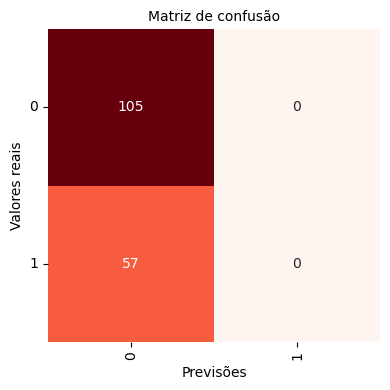

In [28]:
y_pred = mlp_1.predict(X_test_norm.values)
get_accuracy(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

ACURÁCIA: 0.6481


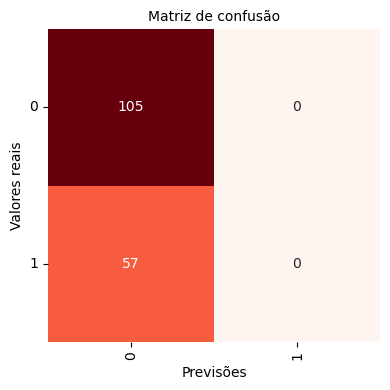

In [29]:
y_pred = mlp_2.predict(X_test_norm.values)
get_accuracy(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

## Algoritmo XGBoost

In [30]:
clf = GradientBoostingClassifier(
    max_depth=2,
    n_estimators=120,
    random_state=0).fit(X_train_norm, y_train)

print(clf.score(X_test_norm, y_test))

print("=-=-=-=-=-=-=")

errors = [mean_squared_error(y_test, y_pred)
          for y_pred in clf.staged_predict(X_test_norm)]

best_n_estimator = np.argmin(errors) + 1

clf_best =  GradientBoostingClassifier(
    max_depth=2,
    n_estimators=best_n_estimator,
    random_state=0).fit(X_train_norm, y_train)

print(clf_best.score(X_test_norm, y_test))

y_pred = clf.predict(X_test_norm)

0.9074074074074074
=-=-=-=-=-=-=
0.9135802469135802


ACURÁCIA: 0.9074
F-SCORE: 0.9074


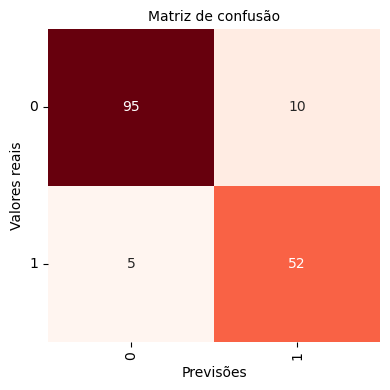

In [31]:
get_accuracy(y_test, y_pred)
f_score(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

### Utilizando a biblioteca xgboost

In [32]:
clf_xgb = xgb.XGBClassifier()

In [33]:
xgb_results = cross_val_score(clf_xgb, X_train_norm.values, y_train, cv=5)
xgb_results.mean()

0.8828771929824561

In [34]:
clf_xgb_modified = xgb.XGBClassifier(max_depth=2)
cross_val_score(clf_xgb_modified, X_train_norm.values, y_train).mean()

0.8856140350877194

In [35]:
class_xgb = xgb.XGBClassifier(booster='gblinear')
cross_val_score(class_xgb, X_train_norm.values, y_train).mean()

0.9016140350877192

In [36]:
class_xgb.fit(X_train_norm.values, y_train)

XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [37]:
y_xgb_pred = class_xgb.predict(X_test_norm)

ACURÁCIA: 0.8951


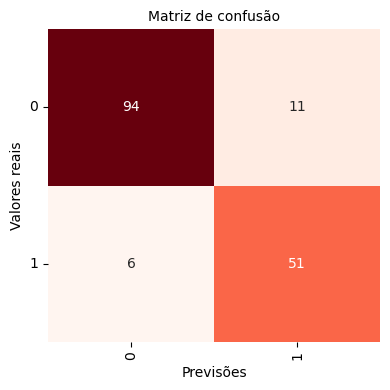

In [38]:
get_accuracy(y_test, y_xgb_pred)
plot_confusion_matrix(y_test, y_xgb_pred)

In [39]:
(y_test == 1).sum(), (y_test == 0).sum(), len(y_test)

(57, 105, 162)

## Validação Cruzada

In [40]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(clf, X, y, cv=kf, scoring='accuracy')

print("Acurácia: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Acurácia: 0.8941 (+/- 0.08)
